In [2]:
import codecs
import multiprocessing
import os
import string
import gensim
import nltk
import numpy as np
from gensim.models.doc2vec import Doc2Vec, LabeledSentence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import logging
from nltk.corpus import stopwords

# 将文档数据，分好词，然后去掉了特殊字符
def splitSentence(content):
    '''
    将文件内容转换成句子
    :param content: 文件内容
    :return: 文件的所有句子
    '''
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    sents = sent_tokenizer.tokenize(content)
    return sents


def cleanLines(sents):
    '''
    句子去掉特殊字符，全部替换成"."
    :param lines:
    :return:
    '''
    sentsResults = []
    for sent in sents:
        delEStr = string.punctuation + string.digits 
        outtab = ""
        for i in range(len(delEStr)):
            outtab += "."
        str_trantab = str.maketrans(delEStr, outtab)
        sent = sent.translate(str_trantab)
        
        sentsResults.append(sent.lower())
       
    return sentsResults


def sentenceToWord(sents):
    '''
    句子截取出单词
    :param sents: 所有的句子
    :return: 截取出的所有单词
    '''
    words = []
    for sent in sents:
        sent_words = nltk.word_tokenize(sent)
        
        #去掉停用词
        list_stopWords=list(set(stopwords.words('english')))
        filtered_words=[w for w in sent_words if not w in list_stopWords]
        
        for word in filtered_words:
            word_splits = word.split(".")
            for key in word_splits:
                if key == "":
                    continue
                else:
                    words.append(key)
    return words


def getWordList(filePath):
    file = open(filePath, "r", errors='ignore')
    sents = splitSentence(file.read())
    sents = cleanLines(sents)
    words = sentenceToWord(sents)
    return words




c:\python35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
words = getWordList("data/alt.atheism/49960")

In [5]:
from collections import Counter
counter = Counter(words)
print(counter.most_common(1000))

[('the', 19), ('atheism', 18), ('s', 15), ('god', 15), ('books', 13), ('alt', 10), ('atheist', 10), ('edu', 10), ('press', 8), ('bible', 8), ('mantis', 7), ('write', 6), ('religion', 6), ('existence', 6), ('swinburne', 6), ('people', 6), ('uk', 6), ('fish', 6), ('history', 6), ('humanism', 5), ('answers', 5), ('cmu', 5), ('prometheus', 5), ('co', 5), ('resources', 5), ('american', 5), ('isbn', 5), ('arguments', 5), ('archive', 4), ('based', 4), ('african', 4), ('christianity', 4), ('p', 4), ('world', 4), ('pages', 4), ('germany', 4), ('usa', 4), ('darwin', 4), ('news', 4), ('telephone', 4), ('addresses', 4), ('new', 4), ('book', 4), ('london', 4), ('publish', 4), ('christian', 4), ('r', 4), ('without', 4), ('mathew', 4), ('belief', 3), ('moderated', 3), ('a', 3), ('und', 3), ('edition', 3), ('exists', 3), ('buffalo', 3), ('mackie', 3), ('mail', 3), ('evolution', 3), ('fiction', 3), ('one', 3), ('designs', 3), ('philosophical', 3), ('also', 3), ('comprehensive', 3), ('postfach', 3), ('g

In [6]:
counter["srv"]

3

In [7]:
#此处如果要重新生成文档向量，需要使用一个模型，模型需要下载，README文件中提供了下载地址
word_model = None
#word_model = gensim.models.KeyedVectors.load_word2vec_format('E:/机器学习/glove/glove_model.txt', binary=False)
# word_model = gensim.models.KeyedVectors.load_word2vec_format('e:/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [11]:


path = "data"

#取词频最高的多少个词
word_count = 500

#得到文档向量 词向量叠加取平均
def getDocVector(filePath):
    words = getWordList(filePath)
    counter = Counter(words)
    vectors = []
    count = 0
    for key in counter.most_common(word_count):
        try:
            vector = word_model[key[0]]
            if len(vectors) == 0:
                vectors = vector
            else:
                vectors = np.add(vector, vectors)
            count += 1
        except:
#             print(key[0],"===============")
            pass
    return  np.divide(vectors, count)






In [12]:
labels = []
x = []
y = []
#将所有的新闻数据得到文档向量和标签
def getAllData(filePath):
    if os.path.isdir(filePath):
        fileList = os.listdir(filePath)
        for file in fileList:
            getAllData(filePath + "/" + file)
    else:
        print(filePath)
        vector = getDocVector(filePath)
        label = filePath.split("/")[-2]
        if label not in labels:
            labels.append(label)
        value = []
        value.append(labels.index(label))
        y.append(value)
        x.append(vector)
        
#将所有数据分割成训练集和测试集
 # 返回x_train,y_train,x_text,y_test
def getData(x, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


In [13]:

#加载数据
if (not os.path.exists("x_train.txt")):
    getAllData(path)
    enc = OneHotEncoder()
    enc.fit(y)
    y = enc.transform(y).toarray()
    x_train, x_test, y_train, y_test = getData(x, y, 0.3)
    np.savetxt("x_train.txt", x_train)
    np.savetxt("y_train.txt", y_train)
    np.savetxt("x_test.txt", x_test)
    np.savetxt("y_test.txt", y_test)
else:
    x_train = np.loadtxt("x_train.txt")
    y_train = np.loadtxt("y_train.txt")
    x_test = np.loadtxt("x_test.txt")
    y_test = np.loadtxt("y_test.txt")

In [19]:
import numpy as np
from keras import optimizers
from keras.layers import Dense, Dropout, regularizers
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)



keep_pro = 0.2
learning_rate = 0.03
epochs = 5000
batch_size = 300

#创建神经网络模型
model = Sequential()
model.add(Dense(100, input_dim=300,activation="relu"))
model.add(Dropout(keep_pro))
model.add(Dense(200, activation="relu"))
model.add(Dropout(keep_pro))
model.add(Dense(300, activation="relu"))
model.add(Dropout(keep_pro))
model.add(Dense(20, activation="softmax"))

#训练模型 使用keras的回调函数提前终止
sgd = optimizers.SGD(lr=learning_rate)
callback_loss = EarlyStopping(monitor="val_loss",patience=100,mode="min")
callback_accuracy = EarlyStopping(monitor="val_acc",patience=100,mode="max")
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2,callbacks=[callback_loss,callback_accuracy])






Train on 11197 samples, validate on 2800 samples
Epoch 1/5000
11197/11197 [==============================] - 1s - loss: 2.9968 - acc: 0.0501 - val_loss: 2.9959 - val_acc: 0.0586
Epoch 2/5000
11197/11197 [==============================] - 0s - loss: 2.9950 - acc: 0.0555 - val_loss: 2.9941 - val_acc: 0.0696
Epoch 3/5000
11197/11197 [==============================] - 0s - loss: 2.9935 - acc: 0.0572 - val_loss: 2.9924 - val_acc: 0.0729
Epoch 4/5000
11197/11197 [==============================] - 0s - loss: 2.9921 - acc: 0.0624 - val_loss: 2.9906 - val_acc: 0.0732
Epoch 5/5000
11197/11197 [==============================] - 0s - loss: 2.9911 - acc: 0.0673 - val_loss: 2.9889 - val_acc: 0.0829
Epoch 6/5000
11197/11197 [==============================] - 0s - loss: 2.9900 - acc: 0.0745 - val_loss: 2.9873 - val_acc: 0.0975
Epoch 7/5000
11197/11197 [==============================] - 0s - loss: 2.9878 - acc: 0.0850 - val_loss: 2.9857 - val_acc: 0.1125
Epoch 8/5000
11197/11197 [======================

11197/11197 [==============================] - 0s - loss: 2.1378 - acc: 0.2262 - val_loss: 2.0599 - val_acc: 0.2889
Epoch 64/5000
11197/11197 [==============================] - 0s - loss: 2.1225 - acc: 0.2363 - val_loss: 2.0472 - val_acc: 0.2993
Epoch 65/5000
11197/11197 [==============================] - 0s - loss: 2.1084 - acc: 0.2340 - val_loss: 2.0268 - val_acc: 0.3039
Epoch 66/5000
11197/11197 [==============================] - 0s - loss: 2.0930 - acc: 0.2444 - val_loss: 2.0142 - val_acc: 0.2900
Epoch 67/5000
11197/11197 [==============================] - 0s - loss: 2.0845 - acc: 0.2439 - val_loss: 1.9952 - val_acc: 0.3214
Epoch 68/5000
11197/11197 [==============================] - 0s - loss: 2.0606 - acc: 0.2412 - val_loss: 1.9830 - val_acc: 0.3236
Epoch 69/5000
11197/11197 [==============================] - 0s - loss: 2.0520 - acc: 0.2498 - val_loss: 1.9638 - val_acc: 0.3350
Epoch 70/5000
11197/11197 [==============================] - 0s - loss: 2.0396 - acc: 0.2544 - val_loss:

11197/11197 [==============================] - 0s - loss: 1.4804 - acc: 0.4475 - val_loss: 1.3697 - val_acc: 0.5164
Epoch 126/5000
11197/11197 [==============================] - 0s - loss: 1.4735 - acc: 0.4467 - val_loss: 1.3782 - val_acc: 0.4979
Epoch 127/5000
11197/11197 [==============================] - 0s - loss: 1.4539 - acc: 0.4565 - val_loss: 1.3447 - val_acc: 0.5221
Epoch 128/5000
11197/11197 [==============================] - 0s - loss: 1.4470 - acc: 0.4624 - val_loss: 1.3607 - val_acc: 0.5254
Epoch 129/5000
11197/11197 [==============================] - 0s - loss: 1.4368 - acc: 0.4692 - val_loss: 1.3427 - val_acc: 0.5161
Epoch 130/5000
11197/11197 [==============================] - 0s - loss: 1.4206 - acc: 0.4700 - val_loss: 1.3234 - val_acc: 0.5239
Epoch 131/5000
11197/11197 [==============================] - 0s - loss: 1.4162 - acc: 0.4709 - val_loss: 1.3247 - val_acc: 0.5332
Epoch 132/5000
11197/11197 [==============================] - 0s - loss: 1.4071 - acc: 0.4750 - va

11197/11197 [==============================] - 0s - loss: 1.0013 - acc: 0.6231 - val_loss: 0.8953 - val_acc: 0.6664
Epoch 188/5000
11197/11197 [==============================] - 0s - loss: 0.9936 - acc: 0.6337 - val_loss: 0.9507 - val_acc: 0.6539
Epoch 189/5000
11197/11197 [==============================] - 0s - loss: 0.9852 - acc: 0.6278 - val_loss: 0.9615 - val_acc: 0.6321
Epoch 190/5000
11197/11197 [==============================] - 0s - loss: 0.9908 - acc: 0.6256 - val_loss: 0.8810 - val_acc: 0.6818
Epoch 191/5000
11197/11197 [==============================] - 0s - loss: 0.9718 - acc: 0.6322 - val_loss: 0.9196 - val_acc: 0.6532
Epoch 192/5000
11197/11197 [==============================] - 0s - loss: 0.9692 - acc: 0.6396 - val_loss: 0.9041 - val_acc: 0.6707
Epoch 193/5000
11197/11197 [==============================] - 0s - loss: 0.9684 - acc: 0.6360 - val_loss: 0.8814 - val_acc: 0.6732
Epoch 194/5000
11197/11197 [==============================] - 0s - loss: 0.9618 - acc: 0.6398 - va

11197/11197 [==============================] - 0s - loss: 0.7572 - acc: 0.7236 - val_loss: 0.6798 - val_acc: 0.7525
Epoch 250/5000
11197/11197 [==============================] - 0s - loss: 0.7453 - acc: 0.7263 - val_loss: 0.6844 - val_acc: 0.7500
Epoch 251/5000
11197/11197 [==============================] - 0s - loss: 0.7532 - acc: 0.7272 - val_loss: 0.7187 - val_acc: 0.7332
Epoch 252/5000
11197/11197 [==============================] - 0s - loss: 0.7421 - acc: 0.7256 - val_loss: 0.6793 - val_acc: 0.7546
Epoch 253/5000
11197/11197 [==============================] - 0s - loss: 0.7334 - acc: 0.7306 - val_loss: 0.6784 - val_acc: 0.7493
Epoch 254/5000
11197/11197 [==============================] - 0s - loss: 0.7384 - acc: 0.7286 - val_loss: 0.7127 - val_acc: 0.7311
Epoch 255/5000
11197/11197 [==============================] - 0s - loss: 0.7565 - acc: 0.7202 - val_loss: 0.6569 - val_acc: 0.7543
Epoch 256/5000
11197/11197 [==============================] - 0s - loss: 0.7622 - acc: 0.7228 - va

11197/11197 [==============================] - 0s - loss: 0.6116 - acc: 0.7766 - val_loss: 0.5515 - val_acc: 0.7993
Epoch 312/5000
11197/11197 [==============================] - 0s - loss: 0.6129 - acc: 0.7801 - val_loss: 0.5667 - val_acc: 0.7936
Epoch 313/5000
11197/11197 [==============================] - 0s - loss: 0.5936 - acc: 0.7854 - val_loss: 0.6427 - val_acc: 0.7539
Epoch 314/5000
11197/11197 [==============================] - 0s - loss: 0.6155 - acc: 0.7779 - val_loss: 0.5359 - val_acc: 0.8046
Epoch 315/5000
11197/11197 [==============================] - 0s - loss: 0.6054 - acc: 0.7817 - val_loss: 0.6217 - val_acc: 0.7650
Epoch 316/5000
11197/11197 [==============================] - 0s - loss: 0.6003 - acc: 0.7850 - val_loss: 0.5924 - val_acc: 0.7807
Epoch 317/5000
11197/11197 [==============================] - 0s - loss: 0.6125 - acc: 0.7804 - val_loss: 0.6483 - val_acc: 0.7614
Epoch 318/5000
11197/11197 [==============================] - 0s - loss: 0.5979 - acc: 0.7821 - va

11197/11197 [==============================] - 0s - loss: 0.5001 - acc: 0.8243 - val_loss: 0.5226 - val_acc: 0.8143
Epoch 374/5000
11197/11197 [==============================] - 0s - loss: 0.5177 - acc: 0.8147 - val_loss: 0.4729 - val_acc: 0.8271
Epoch 375/5000
11197/11197 [==============================] - 0s - loss: 0.5063 - acc: 0.8196 - val_loss: 0.4787 - val_acc: 0.8254
Epoch 376/5000
11197/11197 [==============================] - 0s - loss: 0.5080 - acc: 0.8197 - val_loss: 0.5573 - val_acc: 0.7900
Epoch 377/5000
11197/11197 [==============================] - 0s - loss: 0.5003 - acc: 0.8267 - val_loss: 0.5260 - val_acc: 0.8014
Epoch 378/5000
11197/11197 [==============================] - 0s - loss: 0.5122 - acc: 0.8191 - val_loss: 0.4737 - val_acc: 0.8304
Epoch 379/5000
11197/11197 [==============================] - 0s - loss: 0.4981 - acc: 0.8204 - val_loss: 0.4786 - val_acc: 0.8218
Epoch 380/5000
11197/11197 [==============================] - 0s - loss: 0.4983 - acc: 0.8240 - va

11197/11197 [==============================] - 0s - loss: 0.4329 - acc: 0.8499 - val_loss: 0.4776 - val_acc: 0.8239
Epoch 436/5000
11197/11197 [==============================] - ETA: 0s - loss: 0.4337 - acc: 0.850 - 0s - loss: 0.4332 - acc: 0.8504 - val_loss: 0.4157 - val_acc: 0.8500
Epoch 437/5000
11197/11197 [==============================] - 0s - loss: 0.4396 - acc: 0.8460 - val_loss: 0.4174 - val_acc: 0.8489
Epoch 438/5000
11197/11197 [==============================] - 0s - loss: 0.4377 - acc: 0.8485 - val_loss: 0.4143 - val_acc: 0.8550
Epoch 439/5000
11197/11197 [==============================] - 0s - loss: 0.4292 - acc: 0.8500 - val_loss: 0.5160 - val_acc: 0.8154
Epoch 440/5000
11197/11197 [==============================] - 0s - loss: 0.4336 - acc: 0.8481 - val_loss: 0.4554 - val_acc: 0.8296
Epoch 441/5000
11197/11197 [==============================] - 0s - loss: 0.4283 - acc: 0.8527 - val_loss: 0.4209 - val_acc: 0.8461
Epoch 442/5000
11197/11197 [==============================] 

11197/11197 [==============================] - 0s - loss: 0.3885 - acc: 0.8609 - val_loss: 0.3930 - val_acc: 0.8629
Epoch 498/5000
11197/11197 [==============================] - 0s - loss: 0.3802 - acc: 0.8671 - val_loss: 0.4072 - val_acc: 0.8475
Epoch 499/5000
11197/11197 [==============================] - 0s - loss: 0.3804 - acc: 0.8671 - val_loss: 0.4123 - val_acc: 0.8521
Epoch 500/5000
11197/11197 [==============================] - 0s - loss: 0.3843 - acc: 0.8658 - val_loss: 0.3878 - val_acc: 0.8646
Epoch 501/5000
11197/11197 [==============================] - 0s - loss: 0.3804 - acc: 0.8688 - val_loss: 0.3911 - val_acc: 0.8582
Epoch 502/5000
11197/11197 [==============================] - 0s - loss: 0.3923 - acc: 0.8616 - val_loss: 0.4185 - val_acc: 0.8518
Epoch 503/5000
11197/11197 [==============================] - 0s - loss: 0.3808 - acc: 0.8706 - val_loss: 0.3834 - val_acc: 0.8650
Epoch 504/5000
11197/11197 [==============================] - 0s - loss: 0.3834 - acc: 0.8672 - va

11197/11197 [==============================] - 0s - loss: 0.3357 - acc: 0.8848 - val_loss: 0.3808 - val_acc: 0.8632
Epoch 560/5000
11197/11197 [==============================] - 0s - loss: 0.3456 - acc: 0.8796 - val_loss: 0.3841 - val_acc: 0.8639
Epoch 561/5000
11197/11197 [==============================] - 0s - loss: 0.3539 - acc: 0.8766 - val_loss: 0.4085 - val_acc: 0.8543
Epoch 562/5000
11197/11197 [==============================] - 0s - loss: 0.3480 - acc: 0.8801 - val_loss: 0.3578 - val_acc: 0.8689
Epoch 563/5000
11197/11197 [==============================] - 0s - loss: 0.3378 - acc: 0.8841 - val_loss: 0.4828 - val_acc: 0.8264
Epoch 564/5000
11197/11197 [==============================] - 0s - loss: 0.3429 - acc: 0.8823 - val_loss: 0.3834 - val_acc: 0.8571
Epoch 565/5000
11197/11197 [==============================] - 0s - loss: 0.3380 - acc: 0.8831 - val_loss: 0.4872 - val_acc: 0.8279
Epoch 566/5000
11197/11197 [==============================] - 0s - loss: 0.3363 - acc: 0.8835 - va

11197/11197 [==============================] - 0s - loss: 0.3106 - acc: 0.8889 - val_loss: 0.3794 - val_acc: 0.8646
Epoch 622/5000
11197/11197 [==============================] - 0s - loss: 0.3001 - acc: 0.8977 - val_loss: 0.4331 - val_acc: 0.8454
Epoch 623/5000
11197/11197 [==============================] - 0s - loss: 0.3166 - acc: 0.8893 - val_loss: 0.3596 - val_acc: 0.8721
Epoch 624/5000
11197/11197 [==============================] - 0s - loss: 0.3031 - acc: 0.8921 - val_loss: 0.3862 - val_acc: 0.8596
Epoch 625/5000
11197/11197 [==============================] - 0s - loss: 0.3120 - acc: 0.8929 - val_loss: 0.4277 - val_acc: 0.8461
Epoch 626/5000
11197/11197 [==============================] - 0s - loss: 0.3110 - acc: 0.8930 - val_loss: 0.4007 - val_acc: 0.8564
Epoch 627/5000
11197/11197 [==============================] - 0s - loss: 0.3073 - acc: 0.8901 - val_loss: 0.3426 - val_acc: 0.8782
Epoch 628/5000
11197/11197 [==============================] - 0s - loss: 0.3063 - acc: 0.8969 - va

11197/11197 [==============================] - 0s - loss: 0.2882 - acc: 0.8976 - val_loss: 0.3717 - val_acc: 0.8611
Epoch 684/5000
11197/11197 [==============================] - 0s - loss: 0.2840 - acc: 0.9020 - val_loss: 0.3387 - val_acc: 0.8732
Epoch 685/5000
11197/11197 [==============================] - 0s - loss: 0.2841 - acc: 0.9003 - val_loss: 0.3273 - val_acc: 0.8821
Epoch 686/5000
11197/11197 [==============================] - 0s - loss: 0.2789 - acc: 0.9018 - val_loss: 0.3930 - val_acc: 0.8525
Epoch 687/5000
11197/11197 [==============================] - 0s - loss: 0.2838 - acc: 0.9043 - val_loss: 0.3689 - val_acc: 0.8664
Epoch 688/5000
11197/11197 [==============================] - 0s - loss: 0.2740 - acc: 0.9066 - val_loss: 0.3531 - val_acc: 0.8757
Epoch 689/5000
11197/11197 [==============================] - 0s - loss: 0.2860 - acc: 0.9003 - val_loss: 0.4168 - val_acc: 0.8489
Epoch 690/5000
11197/11197 [==============================] - 0s - loss: 0.2877 - acc: 0.8979 - va

11197/11197 [==============================] - 0s - loss: 0.2591 - acc: 0.9119 - val_loss: 0.3667 - val_acc: 0.8725
Epoch 746/5000
11197/11197 [==============================] - 0s - loss: 0.2639 - acc: 0.9063 - val_loss: 0.3717 - val_acc: 0.8671
Epoch 747/5000
11197/11197 [==============================] - 0s - loss: 0.2541 - acc: 0.9104 - val_loss: 0.3719 - val_acc: 0.8625
Epoch 748/5000
11197/11197 [==============================] - 0s - loss: 0.2606 - acc: 0.9081 - val_loss: 0.3292 - val_acc: 0.8789
Epoch 749/5000
11197/11197 [==============================] - 0s - loss: 0.2651 - acc: 0.9059 - val_loss: 0.4107 - val_acc: 0.8550
Epoch 750/5000
11197/11197 [==============================] - 0s - loss: 0.2609 - acc: 0.9083 - val_loss: 0.4338 - val_acc: 0.8471
Epoch 751/5000
11197/11197 [==============================] - 0s - loss: 0.2604 - acc: 0.9076 - val_loss: 0.3324 - val_acc: 0.8775
Epoch 752/5000
11197/11197 [==============================] - 0s - loss: 0.2601 - acc: 0.9099 - va

11197/11197 [==============================] - 0s - loss: 0.2424 - acc: 0.9130 - val_loss: 0.3693 - val_acc: 0.8618
Epoch 808/5000
11197/11197 [==============================] - 0s - loss: 0.2316 - acc: 0.9198 - val_loss: 0.3291 - val_acc: 0.8775
Epoch 809/5000
11197/11197 [==============================] - 0s - loss: 0.2353 - acc: 0.9144 - val_loss: 0.3344 - val_acc: 0.8782
Epoch 810/5000
11197/11197 [==============================] - 0s - loss: 0.2378 - acc: 0.9165 - val_loss: 0.3223 - val_acc: 0.8832
Epoch 811/5000
11197/11197 [==============================] - 0s - loss: 0.2378 - acc: 0.9160 - val_loss: 0.3470 - val_acc: 0.8725
Epoch 812/5000
11197/11197 [==============================] - 0s - loss: 0.2322 - acc: 0.9144 - val_loss: 0.3369 - val_acc: 0.8796
Epoch 813/5000
11197/11197 [==============================] - 0s - loss: 0.2392 - acc: 0.9170 - val_loss: 0.3587 - val_acc: 0.8664
Epoch 814/5000
11197/11197 [==============================] - 0s - loss: 0.2359 - acc: 0.9174 - va

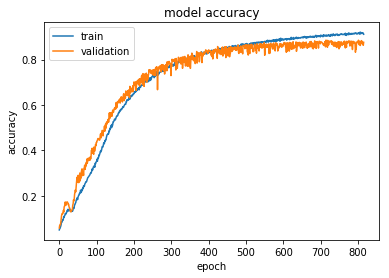

In [20]:
#输出训练集和验证集准确率的图像
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

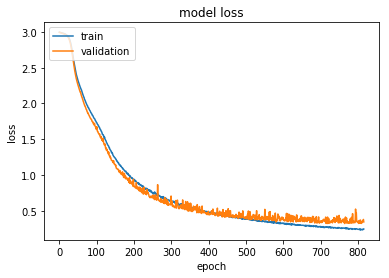

In [21]:
#输出训练集和验证集loss的图像
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
#输出测试集的loss和准确率
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

loss, accuracy = model.evaluate(x_test, y_test)
print("------------")
print("test loss:", loss, "test accuracy", accuracy)

5728/6000 [===========================>..] - ETA: 0s------------
test loss: 0.32099657927 test accuracy 0.887666666667
